<a href="https://colab.research.google.com/github/Alyssl24/MINST/blob/main/Auto_encodeur_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPARATION DES DATALOADERS

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


100%|██████████| 26421880/26421880 [00:06<00:00, 4336795.34it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207425.54it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3782490.76it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5872253.74it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



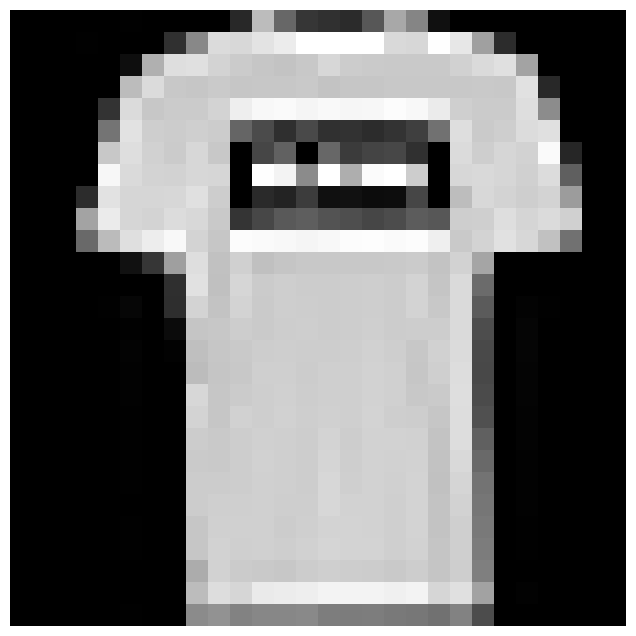

In [ ]:

figure = plt.figure(figsize=(8, 8))
cols, rows = 1,1
for i in range(1, cols * rows + 1):
    img,label = training_data[1]#renvoie image + label (c que limage)
    figure.add_subplot(rows, cols, i)

    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") #affiche l'image
plt.show()

#DATALOADER

In [ ]:
from torch.utils.data import DataLoader #permet de parcourir
batch_size_choose=32

train_dataloader = DataLoader(training_data, batch_size=batch_size_choose, shuffle=True) #le shuffle permet de melanger le set de data
test_dataloader = DataLoader(test_data, batch_size=batch_size_choose, shuffle=True)

# AUTO-ENCODEUR : espace latent 16

In [ ]:
#fonction qui verifie si c correct ou nn
def correct(output, target):
    return torch.sum(output == target).item()

In [ ]:
#boucle qui traite chaques lots de données (data et target sont des listes)
#donc en gros notre BD est separer en lot par le dataloader(qui s"appelle batch)
#puis chaque batch est traite par ses boucles simulatné car c des numpys.

def transformImage(img): #detruit une image ( on peut modifier la destruction ici)

  img[:, : 28 // 2, :] = 0
  return img

def destructData(data): #detruit un ensemble d'image
    newdata=data.clone()
    i=0

    for img in data:

      img2=img.clone()
      img2 =transformImage(img2)  # Remplace la moitié supérieure par des zéros
      newdata[i]=img2
      i+=1

    return newdata




def train(data_loader, model, criterion, optimizer):
    model.train()
    num_batches = len(data_loader)

    total_loss = 0
    total_correct = 0
    i=0
    for data, target in data_loader:
        target=data
        # Do a forward pass
        dataDestruct=destructData(data) #detruit l'image avant de lancer le modele dessus
        output = model(dataDestruct)

        # Calculate the loss
        target=model.flatt(target)
        loss = criterion(output, target)

        total_loss += loss

        # Count number of correct digits

        total_correct += correct(output,target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        i+=1
    print("miaou")
    train_loss = total_loss/num_batches
    accuracy = total_correct/(25088*len(data_loader))  # 25088 = len(ouput)*len(ouput[0])
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

In [ ]:

import tensorflow as tf
class autoencodeur(nn.Module):
    def __init__(self):

        super().__init__()
        self.flatt=nn.Flatten()

        self.line1=nn.Linear(28*28, 256)
        self.relu=nn.ReLU()
        self.line2=nn.Linear(256,64)
        self.line5=nn.Linear(64,16)
        self.line6=nn.Linear(16,64)
        self.line3=nn.Linear(64,256)
        self.line4=nn.Linear(256, 28*28)
        self.dim2=0;
        self.sig=nn.Sigmoid()

    def encoder(self,x):
        x=self.flatt(x)
        x=self.line1(x)
        x=self.relu(x)
        x=self.line2(x)
        x=self.relu(x)
        x=self.line5(x)
        x=self.relu(x)
        return x
    def decoder(self,x):
        x=self.line6(x)
        x=self.relu(x)
        x=self.line3(x)
        x=self.relu(x)
        x=self.line4(x)
        x=self.sig(x)
        return x

    def forward(self, x):
       #x=nn.functional.normalize(x)
        x=self.encoder(x)
        x=self.decoder(x)
        return x

# CREATION ET ENTRAINEMENT DU MODELE

In [ ]:
#CREATION DE NOTRE MODELE
model = autoencodeur()
print(model)

SimpleMLP(
  (flatt): Flatten(start_dim=1, end_dim=-1)
  (line1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (line2): Linear(in_features=256, out_features=64, bias=True)
  (line5): Linear(in_features=64, out_features=16, bias=True)
  (line6): Linear(in_features=16, out_features=64, bias=True)
  (line3): Linear(in_features=64, out_features=256, bias=True)
  (line4): Linear(in_features=256, out_features=784, bias=True)
  (sig): Sigmoid()
)


In [ ]:
criterion = nn.MSELoss(reduction='sum')    #pour l'instant on a choisit celle al est on a des bon resultat
optimizer = torch.optim.Adam(model.parameters()) #on choisit lesquelles ?

In [ ]:
epochs = 10
for epoch in range(epochs):
   print(f"Epoch: {epoch+1} ...")
   train(train_dataloader, model, criterion, optimizer)

Epoch: 1 ...
miaou
Average loss: 825.880554, accuracy: 0.00%
Epoch: 2 ...
miaou
Average loss: 602.399170, accuracy: 0.00%
Epoch: 3 ...
miaou
Average loss: 551.938538, accuracy: 0.00%
Epoch: 4 ...
miaou
Average loss: 522.464233, accuracy: 0.00%
Epoch: 5 ...
miaou
Average loss: 502.152222, accuracy: 0.00%
Epoch: 6 ...
miaou
Average loss: 487.413666, accuracy: 0.00%
Epoch: 7 ...
miaou
Average loss: 474.890015, accuracy: 0.00%
Epoch: 8 ...
miaou
Average loss: 466.439728, accuracy: 0.00%
Epoch: 9 ...
miaou
Average loss: 460.209259, accuracy: 0.00%
Epoch: 10 ...
miaou
Average loss: 454.301941, accuracy: 0.00%


# AFFICHAGE IMAGE RECONSTRUCTION


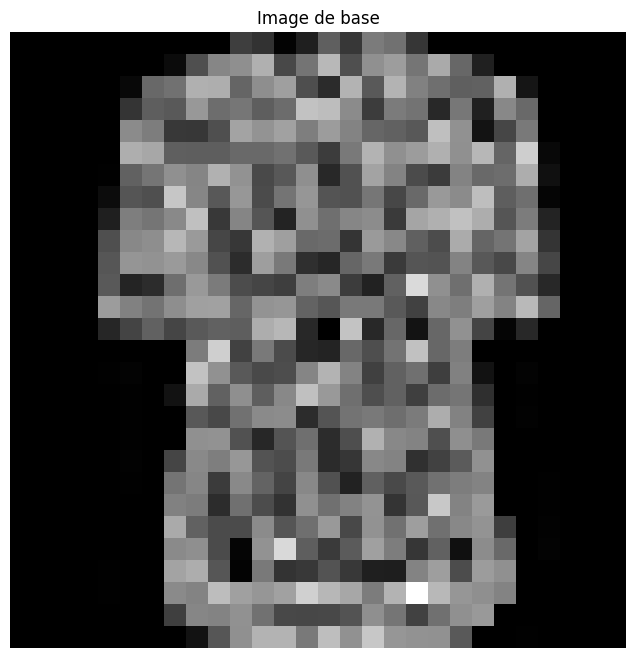

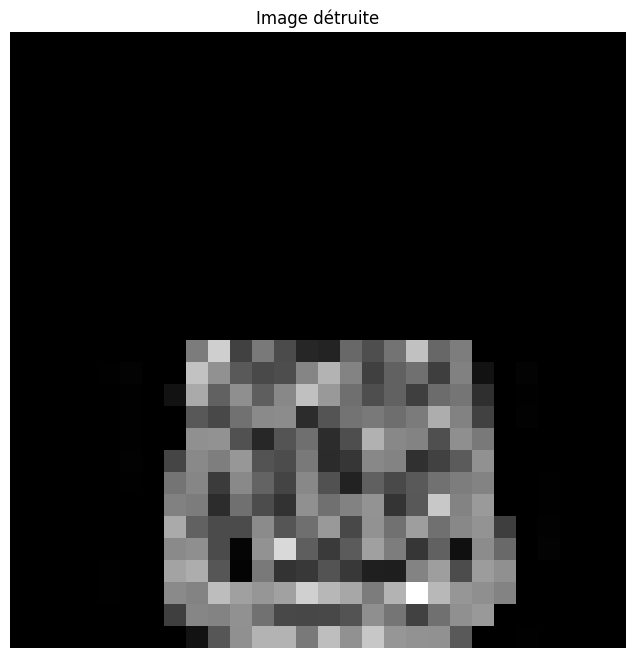

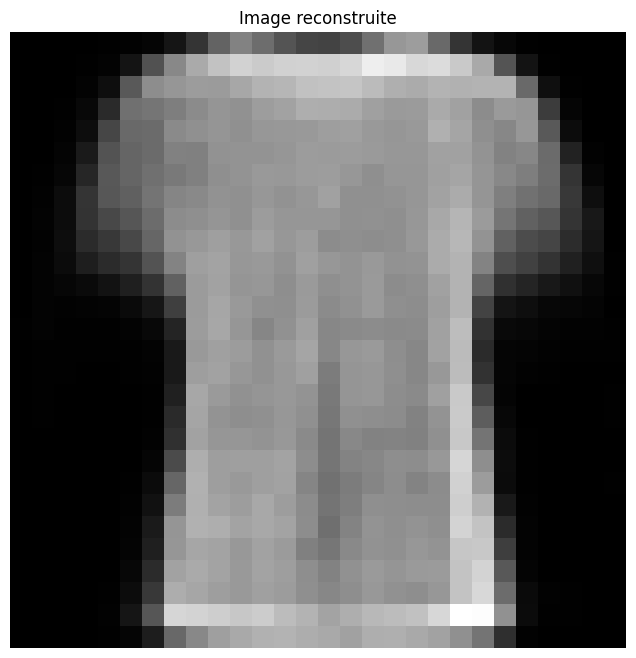

In [ ]:
imageNum=563

img=test_data[imageNum][0]
figure = plt.figure(figsize=(8, 8))
cols, rows = 1,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() #genere un index aleatoire
    figure.add_subplot(rows, cols, i)
    plt.title("Image de base")
    plt.axis("off")
    plt.imshow(img.numpy().squeeze(), cmap="gray") #affiche l'image
plt.show()



img=transformImage(test_data[imageNum][0]) #destruction de l'image pour lancer le modele dessus
figure = plt.figure(figsize=(8, 8))
cols, rows = 1,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() #genere un index aleatoire
    figure.add_subplot(rows, cols, i)
    plt.title("Image détruite")
    plt.axis("off")
    plt.imshow(img.numpy().squeeze(), cmap="gray") #affiche l'image
plt.show()


figure = plt.figure(figsize=(8, 8))
cols, rows = 1,1


predis=np.array(model.forward(test_data[imageNum][0]).tolist()).reshape(28,28)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() #genere un index aleatoire
    img=predis
    figure.add_subplot(rows, cols, i)
    plt.title("Image reconstruite")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") #affiche l'image
plt.show()